# In Memory of Kobe Bryant 

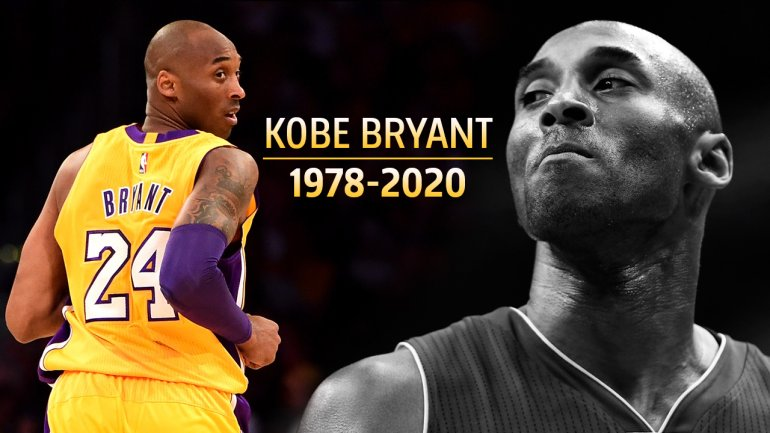

In [1]:
from IPython.display import Image
Image('C:/Users/Public/medium_kobe/kobe_image.jpg', width=780)

# Prerequisite

In [2]:
# Set working directory
import os
os.chdir("C:/Users/Public/medium_kobe/")
print(os.getcwd())

# Import library
import pandas as pd
import numpy as np
import time
from datetime import date
import ipywidgets as widgets
from itertools import accumulate
from IPython.display import display_html

# Preprocess data  
kobe_data = pd.read_csv("kobe.csv")
data = kobe_data.copy() #copy, to construct whole new dataset
# Transform type of shot_type value into numeric
data["shot_type_value"] = data["shot_type"].apply(lambda x: 2 if x=="2PT Field Goal" else 3) #map
data["points"] = data["shot_type_value"] * data["shot_made_flag"] #transform
data['game_date'] =pd.to_datetime(data['game_date']) #data time
data.sort_values("game_date",inplace=True)
data.index =list(range(len(data)))
opponent_list = list(np.unique(data.opponent))

# The data for the date after Kobe changed his number
NBA_season_2006_7_start = date(2006, 10, 31)
NBA_season_2006_7_end = date(2007, 4, 19)
NBA_season_2006_7_interval = pd.date_range(start=NBA_season_2006_7_start, end=NBA_season_2006_7_end)
newdata_index = data[data["game_date"].isin(NBA_season_2006_7_interval)].index[0]
kobe_24_data = data.iloc[newdata_index:]
kobe_8_data = data.iloc[:newdata_index]
print("Overall data", len(data))
print("Kobe 8 data", len(kobe_8_data))
print("Kobe 24 data", len(kobe_24_data))

C:\Users\Public\medium_kobe
Overall data 30697
Kobe 8 data 15381
Kobe 24 data 15316


# 1. Kobe's performance against any team.

## Calculate the average 2 points, 3 points field goal rate, and  gained scores against any team.

In [3]:
def record(opponent):
    def Mean_FGR(Input, opponent):
        data_1 = Input.copy()
        data_1.index = data_1.opponent
        data_1_final = data_1.loc[[opponent],["shot_type","shot_made_flag"]].groupby("shot_type").mean()
        data_1_final.rename(columns ={"shot_made_flag":"Average_field_goal_rate"},inplace = True) #Rename colunm
        return(data_1_final.style.set_table_attributes("style='display:inline'"))

    def mean_scores(Input, opponent):
        data_2 = Input.copy()
        data_2 = data_2[["game_date", "opponent", "points"]] #subset
        data_2_group = data_2.groupby(["game_date","opponent"], as_index=False).sum() #aggregate
        data_2_mean = data_2_group.groupby("opponent").mean()
        data_2_mean_oppo = data_2_mean[data_2_mean.index == opponent]
        return(data_2_mean_oppo.style.set_table_attributes("style='display:inline'"))
    print("\x1b[31m Kobe entire career ""\x1b[0m") 
    df1_styler = Mean_FGR(data, opponent)
    df2_styler = mean_scores(data, opponent)
    display_html(df1_styler._repr_html_()+" "+ df2_styler._repr_html_(), raw=True)
    print("\x1b[31m Kobe 8 period ""\x1b[0m")   
    df1_styler = Mean_FGR(kobe_8_data, opponent)
    df2_styler = mean_scores(kobe_8_data, opponent)
    display_html(df1_styler._repr_html_()+" "+ df2_styler._repr_html_(), raw=True)
    print("\x1b[31m Kobe 24 period ""\x1b[0m")   
    df1_styler =Mean_FGR(kobe_24_data, opponent)
    df2_styler = mean_scores(kobe_24_data, opponent)
    display_html(df1_styler._repr_html_()+" "+ df2_styler._repr_html_(), raw=True)   

In [4]:
widgets.interact(record, 
    opponent = widgets.Dropdown(value = "HOU", description = "Opponent", options = opponent_list));

interactive(children=(Dropdown(description='Opponent', index=10, options=('ATL', 'BKN', 'BOS', 'CHA', 'CHI', '…

# 2. Toughest Teams Kobe Has Competed against In His Career
## Find the 5 teams making Kobe get the lowest average scores in whole career.

In [5]:
#(2) OK
data_2 = data.copy()
data_2 = data_2[["game_date", "opponent", "points"]] #subset
data_2_group = data_2.groupby(["game_date","opponent"], as_index=False).sum() #aggregate
data_2_group.groupby("opponent").mean().sort_values("points").head(5)

,points
opponent,
VAN,11.166667
BKN,12.666667
IND,14.025641
UTA,14.142857
NJN,14.178571


# 3. Kobe's clutch moments in NBA playoff.
## Find the games in which Kobe got the highest scores during the last 3 minutes in the playoff.

In [6]:
#(3)OK
data_3 = data.copy() #copy
data_3 = data_3[["playoffs", "game_date","matchup", "period", "minutes_remaining", "points"]] #subset
data_3_playoffs = data_3[(data_3.playoffs==1) & (data_3.period==4)& (data_3.minutes_remaining<=2)  ]
data_3_playoffs = data_3_playoffs.drop(["playoffs", "period", "minutes_remaining"],axis = 1)
data_3_playoffs.groupby(["game_date","matchup"]).sum().sort_values("points",ascending = False).head(5)

,,points
game_date,matchup,
2000-06-02,LAL @ POR,9
2002-05-12,LAL @ SAS,8
2000-04-30,LAL @ SAC,7
2008-06-08,LAL @ BOS,7
2002-06-07,LAL vs. NJN,6


# 4. Is Kobe the best closer?
## List the Jump-shot  Field Goal Percentage of Kobe in the last one minute in every season playoff.

In [7]:
#(4)OK
def color_negative_red(val):
    """
    Takes a scalar and returns a string with
    the css property `'color: red'` for negative
    strings, black otherwise.
    """
    if isinstance(val, float):
        color = 'red' if val >= 0.5 else 'black'
        return 'color: %s' % color
    else:
        return val

data_4 = kobe_data.copy() #copy
data_4 = data_4[["playoffs", "season", "action_type", "shot_made_flag", "period", "minutes_remaining"]] #subset
data_4_select = data_4[(data_4.playoffs==1) & (data_4.period==4)& (data_4.minutes_remaining<1)& (data_4.action_type =="Jump Shot") ]
data_4_select = data_4_select.drop(["playoffs", "period", "minutes_remaining", "action_type"],axis = 1)
data_4_select = data_4_select.groupby(["season"], as_index=False).mean()
for i in list(set(data.season) - set(data_4_select.season)):
    data_4_select=data_4_select.append({'season' : i , 'shot_made_flag' : "No shooting record"} , ignore_index=True)
index = {'1996-97':1,'1997-98':2,'1998-99':3,'1999-00':4,'Jan-00':5, 'Feb-01':6, 'Mar-02':7, 'Apr-03':8, 'May-04':9, 'Jun-05':10,
     'Jul-06':11, 'Aug-07':12, 'Sep-08':13, 'Oct-09':14, 'Nov-10':15, 'Dec-11':16,
       '2012-13':17, '2013-14':18, '2014-15':19, '2015-16':20}
data_4_select["order"] = data_4_select.season.map(index)
data_4_final = data_4_select.sort_values("order");del data_4_final["order"]
data_4_final = data_4_final.style.applymap(color_negative_red)
data_4_final

,season,shot_made_flag
0,1996-97,0.4
1,1997-98,0
2,1998-99,0.142857
3,1999-00,0.1
8,Jan-00,0
7,Feb-01,0.5
11,Mar-02,0.333333
4,Apr-03,0.166667
18,May-04,No shooting record
10,Jun-05,0


# 5. Kobe's "hot hand" performance
## List the longest consecutive games which Kobe got at least 33% FGP.

In [8]:
#(5)OK
def continuous_split(series): 
    total_time = iteration = len(series)-1
    split = [[],[],[]]
    while iteration >0:
        if series[total_time-iteration]==0:
            iteration -=1
        else:
            times = 0
            begin = total_time-iteration
            while (series[total_time-iteration] ==1) and (iteration>0):
                times +=1
                iteration -=1
            end = total_time-iteration-1
            split[0].append(times)
            split[1].append(begin)
            split[2].append(end)
    return split
data_5 = data.copy()
data_5 = data_5[["shot_made_flag", "game_date"]]
data_5_group = data_5.groupby("game_date").mean()
data_5_group.rename(columns ={"shot_made_flag":"Average_field_goal_rate"},inplace = True) #Rename colunm
data_5_group["target"] = data_5_group.Average_field_goal_rate.apply(lambda x: 1 if x>=0.33 else 0) 
index = continuous_split(data_5_group["target"])
d = {'length': index[0], 'begin': index[1], 'end' : index[2]}
df = pd.DataFrame(d)
df_result = df.sort_values("length",ascending = False).head(4)
df_result["Starting_date"] = df_result["begin"].apply(lambda x: data_5_group.index[x])
df_result["Ending_date"] = df_result["end"].apply(lambda x: data_5_group.index[x])
del df_result["begin"];del df_result["end"]
df_result


,length,Starting_date,Ending_date
60,19,2000-02-01,2000-03-12
85,19,2001-06-15,2001-12-07
89,16,2002-01-14,2002-02-17
131,14,2004-01-02,2004-02-25


# 6. Kobe's worst status in the games.
## List the games which Kobe got the lowest FGP and gained more scores in the first half than the second one.

In [9]:
#(6) OK
#Collect opponent, Average_field_goal_rate, points columns
fg_data = data.copy() #copy
fg_data = fg_data[["game_date", "shot_made_flag", "opponent"]] #subset
fg_data_group = fg_data.groupby(["game_date","opponent"]).mean() #aggregate
fg_data_group = fg_data_group.reset_index(level="opponent") #reset index
fg_data_group.rename(columns ={"shot_made_flag":"Average_field_goal_rate"},inplace = True) #Rename colunm
data_p = data.copy() #copy
data_p = data_p[["game_date", "points"]] #subset
data_p_group = data_p.groupby(["game_date"]).sum() #aggregate
data_O_A_P = pd.concat([fg_data_group,data_p_group],axis = 1) #combine

#Collect FH:First half scores, SH:Second half scores, Points_spread:FH and  SH spread
data_6 = data.copy() #copy
data_6 = data.loc[:,["game_date","period", "points"]] #subset
data_6.period = data_6.period.astype("str") #corerce
quarter = {'1':'FH','2':'FH', '3':'SH', '4':'SH', '5':'OT1','6':'OT2', '7':'OT3'} #index (map)
data_6['quarter'] = data_6.period.map(quarter) #map
data_6_part = data_6[data_6.quarter.isin(["FH","SH"])] #index(mask)
del data_6_part["period"] # remove column
x = data_6_part.groupby(["game_date", "quarter"]).sum() #aggregate
data_6_final = x.unstack(level = -1) #flatten
data_6_final= data_6_final.fillna(0) #fill NaN
data_6_final.columns = data_6_final.columns.droplevel(0) #Remove Hierachy
data_6_final = data_6_final.rename_axis(None, axis=1) #Remove Hierachy
data_6_final["Points_spread"]  = data_6_final.FH -data_6_final.SH
data_6_final = pd.concat([data_O_A_P, data_6_final] ,axis = 1)
data_6_final = data_6_final[data_6_final.Points_spread > 0]
data_6_final.sort_values("Average_field_goal_rate",ascending = False).tail(3)

,opponent,Average_field_goal_rate,points,FH,SH,Points_spread
game_date,,,,,,
2003-12-21,PHX,0.083333,2,2.0,0.0,2.0
2016-04-05,LAC,0.083333,2,2.0,0.0,2.0
2015-11-24,GSW,0.071429,3,3.0,0.0,3.0


# 7. Is Kobe a persistent bricklayer?
## List  the maximum of Kobe's continuous missing shot in one game.

In [10]:
#(7)
#Part 1
data = kobe_data.copy() #copy, to construct scores dataset
data["shot_type_value"] = data["shot_type"].apply(lambda x: 2 if x=="2PT Field Goal" else 3) #map
data["points"] = data["shot_type_value"] * data["shot_made_flag"] #transform
data_7 = data
data_7 = data_7.loc[:,["game_date", "game_id", "opponent","shot_made_flag", "points"]]
data_7_group = data_7.groupby(["game_date", "game_id", "opponent"],as_index = False).points.sum()
shot_made_flag_interval = []
for idx, value in data_7.groupby(["game_date", "game_id", "opponent"]):
    series = value["shot_made_flag"]
    series = pd.Series(series)
    series.index = list(range(len(series)))
    shot_made_flag_interval.append(pd.Series(series))
#Part2
max_continuity_miss = []
for sub in shot_made_flag_interval:
    series = sub
    total_time = iteration = len(series)-1
    split = []
    while iteration >=0:
        if series[total_time-iteration]==1:
            iteration -=1
        else:
            times = 0
            while (iteration >= 0) and (series[total_time-iteration] ==0):
                times +=1
                iteration -=1
            split.append(times)
    if len(split)==0:
        result =0
    else:
        result = max(split)
    max_continuity_miss.append(result)

data_7_group.loc[:,"Continuous_missing_shot"] = max_continuity_miss
data_final = data_7_group.sort_values("Continuous_missing_shot", ascending = False)
data_final.head(5)

,game_date,game_id,opponent,points,Continuous_missing_shot
1221,2010/4/2,20901131,UTA,8,16
1506,2015/12/1,21500263,PHI,10,16
1381,2012/3/31,21100769,NOH,7,15
579,2003/3/12,20200925,DET,12,15
710,2005/11/18,20500130,LAC,14,14
